In [1]:
import sys
from pathlib import Path
import matplotlib.pyplot as plt

import torch
from torchvision import transforms
from torchvision.datasets import MNIST, EMNIST
from tqdm import trange
from os import PathLike
from typing import Optional

C:\Users\akgo1\anaconda3\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\akgo1\anaconda3\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
from source import SplitNN, Attacker

In [3]:
project_root = Path.cwd().resolve()
im_save_path = project_root / "results"

In [4]:
device = torch.device("cpu" if not torch.cuda.is_available() else "cuda:0")

In [5]:
#Funtion to plot MNIST data

def def_plot(ims, save_path):
    
    fig = plt.figure(figsize=(15, 8))

    n_tensors = len(ims)
    n_cols = 4
    n_rows = 4

    mu = torch.tensor([0.1307], dtype=torch.float32)
    sigma = torch.tensor([0.3081], dtype=torch.float32)
    Unnormalise = transforms.Normalize((-mu / sigma).tolist(), (1.0 / sigma).tolist())

    for row in range(n_rows):
        for col in range(n_cols):
            idx = n_cols * row + col

            ax = fig.add_subplot(n_rows, n_cols, idx + 1)
            tensor = Unnormalise(ims[idx])

            tensor[tensor < 0] = 0
            tensor[tensor > 1] = 1

            ax.imshow(transforms.ToPILImage()(tensor), interpolation="bicubic")
            ax.set_yticklabels([])
            ax.set_xticklabels([])

    plt.show()
    plt.savefig(save_path)

## Loading model

In [6]:
target_model_path = 'C:/Users/akgo1/CS 498/Project/models/nopeek_0_15weight.pth'

In [7]:
target_model = SplitNN()

checkpoint = torch.load(target_model_path)
target_model.load_state_dict(checkpoint["model_state_dict"])

target_model = target_model.to(device)
target_model.eval()

SplitNN(
  (encode): Sequential(
    (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Flatten(start_dim=1, end_dim=-1)
    (6): Linear(in_features=9216, out_features=500, bias=True)
  )
  (decode): Sequential(
    (0): Linear(in_features=500, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=10, bias=True)
    (3): Softmax(dim=1)
  )
)

In [8]:
data_transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,)),
        ])

## Testing performance of loaded model

In [9]:
mnist_test = MNIST(project_root / "data", download=True, train=False, transform=data_transform)
mnist_test.data = mnist_test.data[:50000]
mnist_test.targets = mnist_test.targets[:50000]

mnist_test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=1000)

In [10]:
target_test_correct = 0
target_test_total = 0

for data, targets in mnist_test_loader:
    data = data.to(device)
    targets = targets.to(device)

    with torch.no_grad():
        outputs, _ = target_model(data)

    target_test_correct += outputs.max(1)[1].eq(targets).sum().item()
    target_test_total += outputs.size(0)

target_test_accuracy = 100 * target_test_correct / target_test_total
print(f"Target model accuracy: {target_test_accuracy:.3f}")

Target model accuracy: 65.610


## Training Attacker model

#### Training the attacker on EMNIST, since in a real-world scenario the attacker might not have access to the real training data. 

In [150]:
emnist_train = EMNIST(project_root / "data", "letters", download=True, train=True, transform=data_transform)
emnist_train.data = emnist_train.data[: 5000]
emnist_train.targets = emnist_train.targets[: 5000]

emnist_loader = torch.utils.data.DataLoader(emnist_train, batch_size=128)

In [151]:
attack_model = Attacker().to(device)
attack_model.train()
attack_optim = torch.optim.Adam(attack_model.parameters(), lr=1e-4)

for epoch in trange(5):
    for data, _ in emnist_loader:
        attack_optim.zero_grad()

        data = data.to(device)

        # Get target model output
        with torch.no_grad():
            intermediate_data = target_model.encode(data)
            

        reconstructed_data = attack_model(intermediate_data)

        loss = ((reconstructed_data - data)**2).mean()
        loss.backward()
        attack_optim.step()

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [01:52<00:00, 22.55s/it]


In [152]:
mnist_test = MNIST(project_root / "data", download=True, train=False, transform=data_transform)
mnist_test.data = mnist_test.data[5000:]
mnist_test.targets = mnist_test.targets[5000:]

## Visualizing Reconstruction Attack

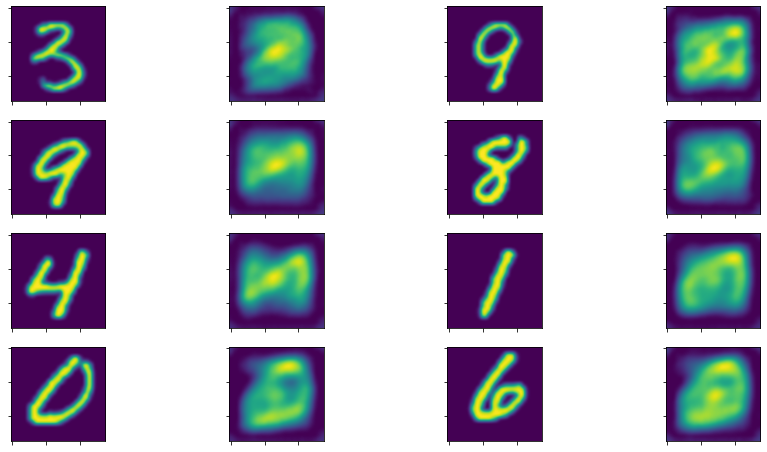

<Figure size 432x288 with 0 Axes>

In [153]:
ims = []
save_path = "results/" + target_model_path.split('/')[-1].split('.')[0] + ".png"

for i in range(10):
    image, _ = mnist_test[i]

    with torch.no_grad():
        intermediate = target_model.encode(image.unsqueeze(0))
        reconstructed = attack_model(intermediate)

    reconstructed = reconstructed.squeeze(0)
    ims.extend([image, reconstructed])

def_plot(ims, save_path)